In [1]:
!pip install tensorflow-gpu

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp gdrive/My\ Drive/*.npy .
!cp gdrive/My\ Drive/*.py .
!ls -l

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 5395460
drwxr-xr-x 2 root root       4096 Mar 20 16:54 09
-rw------- 1 root root       2875 Mar 20 17:56 _dataset_tools.py
drwx------ 3 root root       4096 Mar 20 16:34 gdrive
-rw------- 1 root root       1645 Mar 20 17:56 _my_tools.py
drwxr-xr-x 2 root root       4096 Mar 20 17:47 __pycache__
drwxr-xr-x 1 root root       4096 Mar  8 17:26 sample_data
-rw------- 1 root root  920825984 Mar 20 17:55 X_test.npy
-rw------- 1 root root 2762440832 Mar 20 17:56 X_train.npy
-rw------- 1 root root  460413056 Mar 20 17:56 y_test.npy
-rw------- 1 root root 1381220480 Mar 20 17:56 y_train.npy


In [0]:
import tensorflow as tf
from tensorflow import keras
import _my_tools as mt
import numpy as np

def compareRes(i,folder=None):
    mt.showImgGC(str(i).zfill(2),X_test[i,:,:,0],y_test[i,:,:,0],res[i,:,:,0],X_test[i,:,:,1],folder=folder)
    
def compareResT(i,folder=None):
    mt.showImgGC(str(i).zfill(2),X_train[i,:,:,0],y_train[i,:,:,0],res[i,:,:,0],X_train[i,:,:,1],folder=folder)

In [0]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

X_train = X_train.astype('float16')
y_train = y_train.astype('float16')
X_test = X_test.astype('float16')
y_test = y_test.astype('float16')
X_train /= 255
y_train /= 255
X_test /= 255
y_test /= 255

In [0]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(149872, 96, 96, 2)
(149872, 96, 96, 1)
(49958, 96, 96, 2)
(49958, 96, 96, 1)


In [0]:
# X_train, y_train, X_test, y_test = mt.loadDataFloat("")

X_train = X_train.swapaxes(1,3)
X_train = X_train.swapaxes(1,2)
X_test = X_test.swapaxes(1,3)
X_test = X_test.swapaxes(1,2)

y_train = np.expand_dims(y_train,3)
y_test = np.expand_dims(y_test,3)

In [0]:
X_train.shape

(166525, 2, 96, 96)

In [0]:
def convBlock(x, depth):
  l = keras.layers.Conv2D(depth,(3,3),activation='relu',padding='same')(x)
  l = keras.layers.Conv2D(depth,(3,3),activation='relu',padding='same')(l)
  l = keras.layers.MaxPooling2D((2,2),padding='same')(l)
  
  return l

def deconvBlock(x, depth):
  l = keras.layers.Conv2DTranspose(depth,(4,4),strides=2,padding='same',activation='relu')(x)
  l = keras.layers.Conv2D(depth,(3,3),activation='relu',padding='same')(l)
  
  return l
  


input_img = keras.layers.Input((96,96,2))

c1 = convBlock(input_img, 32)
c2 = convBlock(c1, 64)
c3 = convBlock(c2, 128)
c4 = convBlock(c3, 256)
# encoded = convBlock(c4, 512)

# d4 = deconvBlock(c4,256)
# d4 = keras.layers.Add()([c4,d4])
# d4 = keras.layers.ReLU()(d4)
# --
d3 = deconvBlock(c4, 128)
d3 = keras.layers.Add()([c3,d3])
d3 = keras.layers.ReLU()(d3)
# --
d2 = deconvBlock(d3, 64)
d2 = keras.layers.Add()([c2,d2])
d2 = keras.layers.ReLU()(d2)
# --
d1 = deconvBlock(d2, 32)
d1 = keras.layers.Add()([c1,d1])
d1 = keras.layers.ReLU()(d1)
# --
# decoded = deconvBlock(d1, 1)
l = keras.layers.Conv2DTranspose(1,(4,4),strides=2,padding='same',activation='relu')(d1)
decoded = keras.layers.Conv2D(1,(3,3),activation='sigmoid',padding='same')(l)
  
# out = keras.layers.Activation('sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_absolute_error')

In [0]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=False)

Using TensorFlow backend.


In [18]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 2)    0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 96, 96, 32)   608         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 96, 96, 32)   9248        conv2d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 48, 48, 32)   0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 

In [14]:
checkpoint_path = "09/cp"
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             save_weights_only=True,
                                             verbose=1)

batch_size = 16
num_epoch = 20
#model training
model_log = autoencoder.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,          
          validation_data=(X_test, y_test),
          callbacks = [cp_callback])

Train on 149872 samples, validate on 49958 samples
Epoch 1/20
149856/149872 [============================>.] - ETA: 0s - loss: 0.8960
Epoch 00001: saving model to 09/cp

Consider using a TensorFlow optimizer from `tf.train`.
149872/149872 [==============================] - 757s 5ms/sample - loss: 0.8960 - val_loss: 0.4029
Epoch 2/20
149856/149872 [============================>.] - ETA: 0s - loss: 0.3899
Epoch 00002: saving model to 09/cp

Consider using a TensorFlow optimizer from `tf.train`.
149872/149872 [==============================] - 750s 5ms/sample - loss: 0.3899 - val_loss: 0.3712
Epoch 3/20
149856/149872 [============================>.] - ETA: 0s - loss: 0.3603
Epoch 00003: saving model to 09/cp

Consider using a TensorFlow optimizer from `tf.train`.
149872/149872 [==============================] - 767s 5ms/sample - loss: 0.3603 - val_loss: 0.3410
Epoch 4/20
149856/149872 [============================>.] - ETA: 0s - loss: 0.3455
Epoch 00004: saving model to 09/cp

Consider us

KeyboardInterrupt: ignored

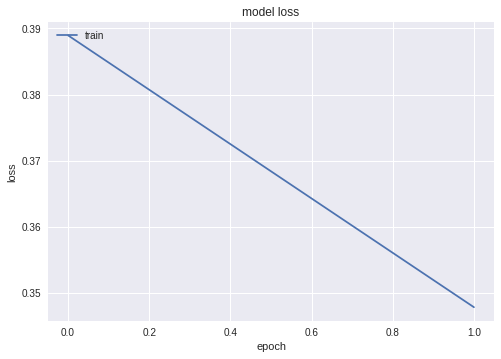

In [21]:
import matplotlib.pyplot as plt

plt.plot(model_log.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()


# model_log.history.keys()

In [0]:
autoencoder.load_weights("09/cp")

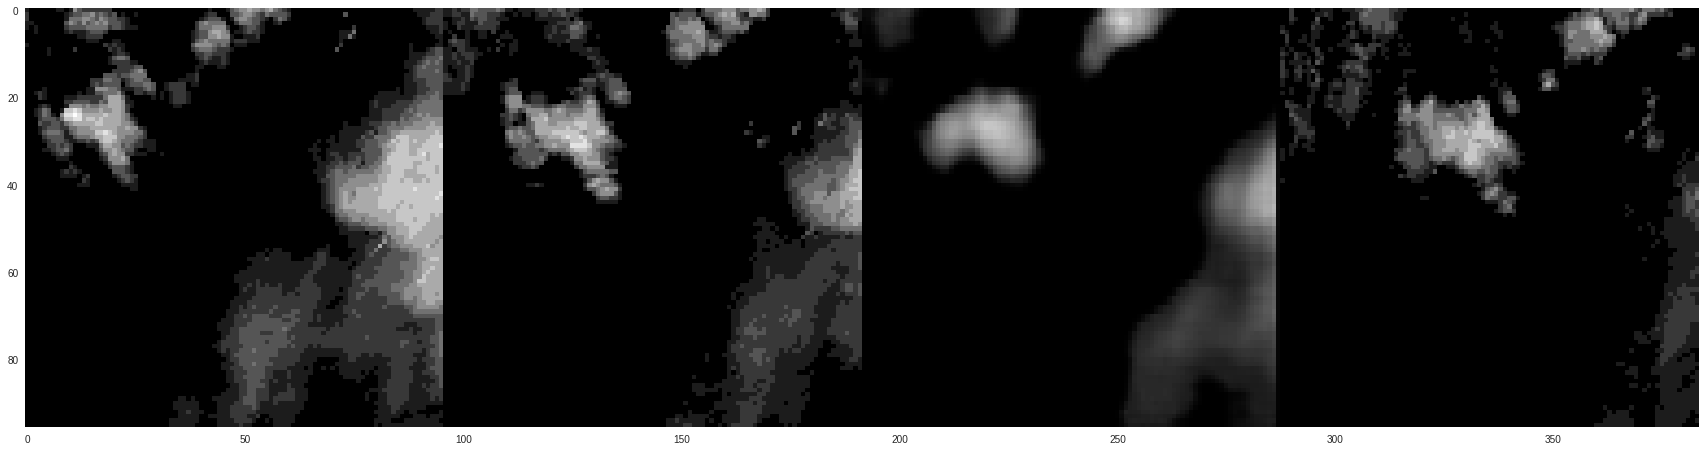

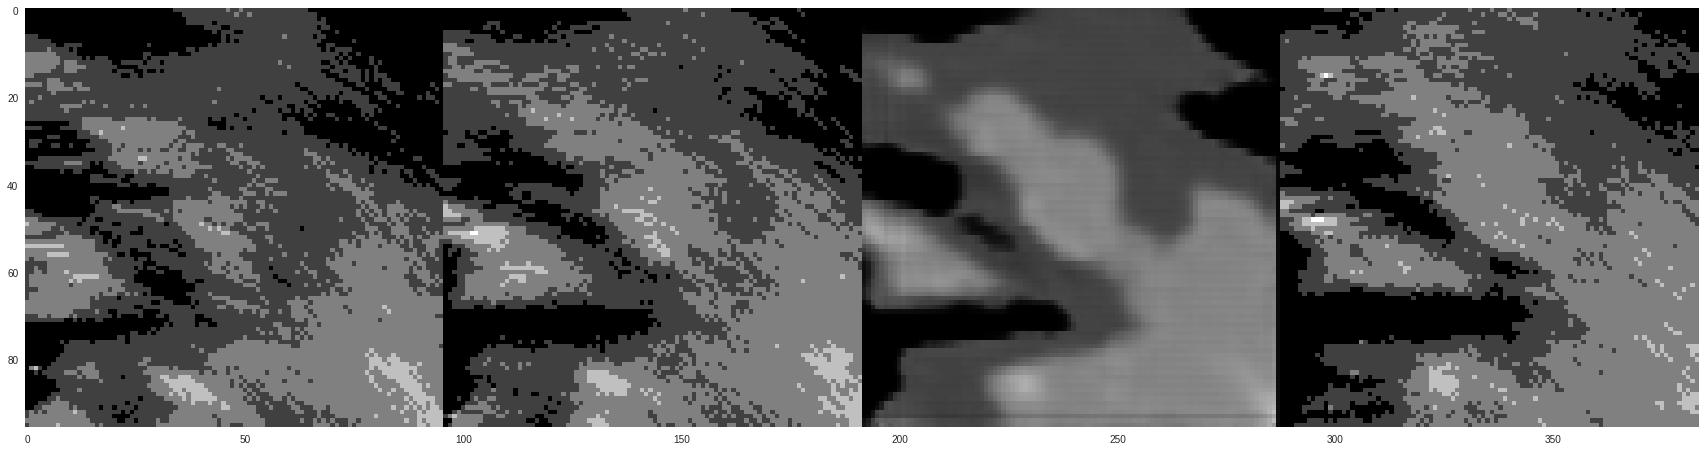

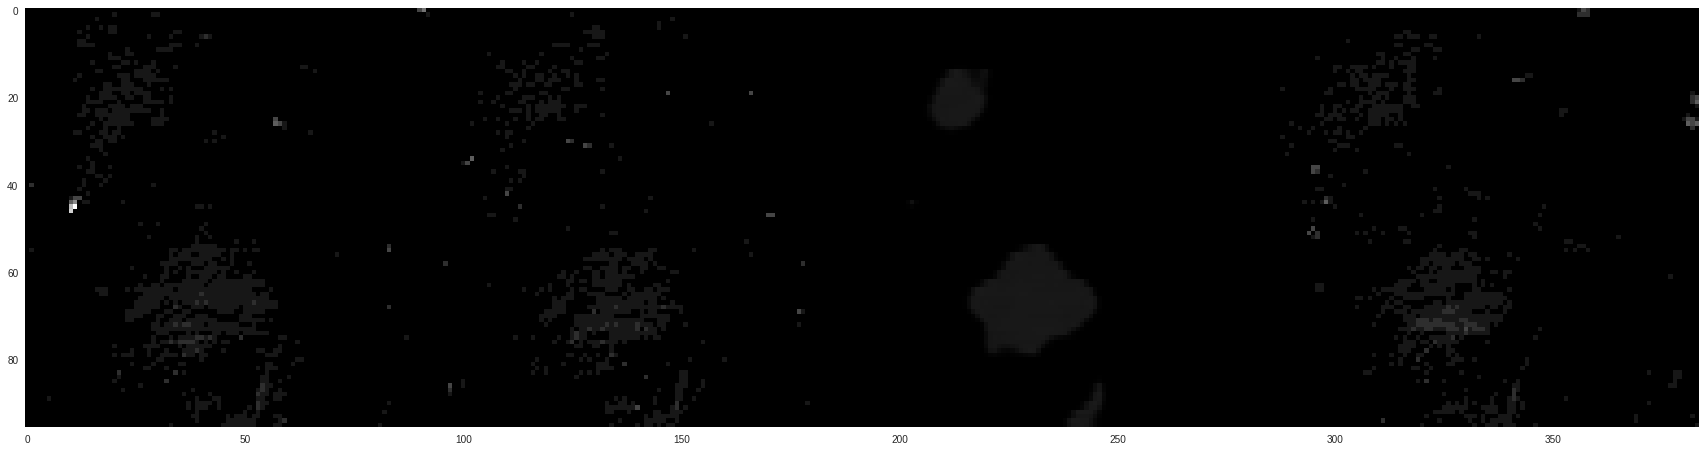

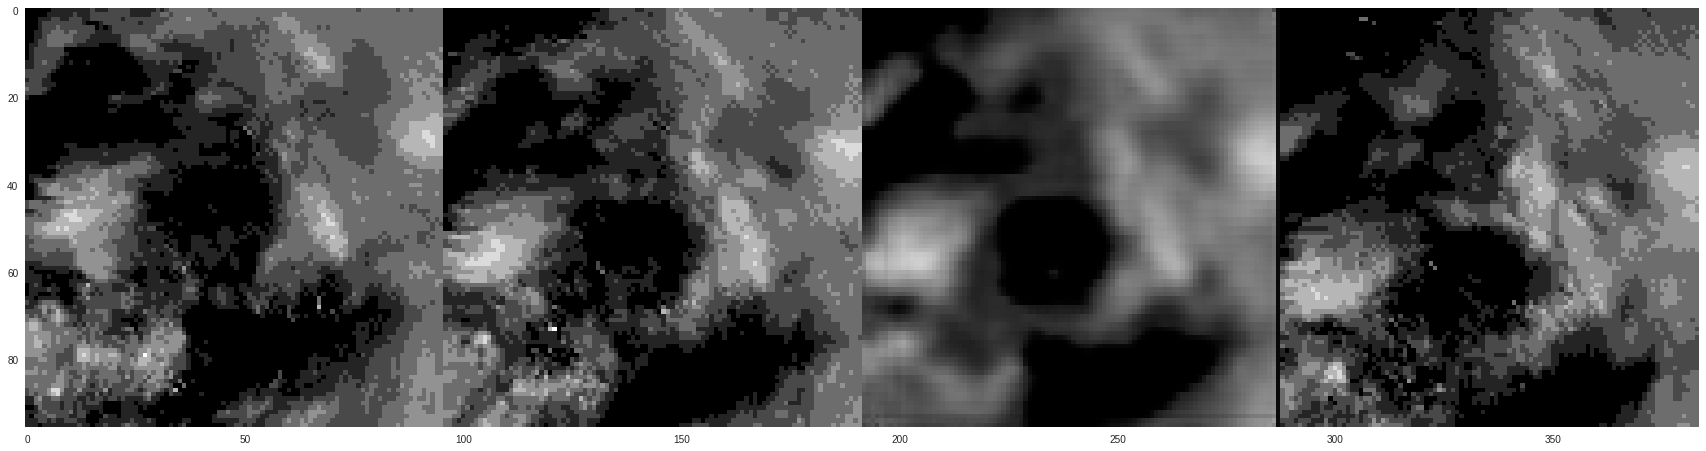

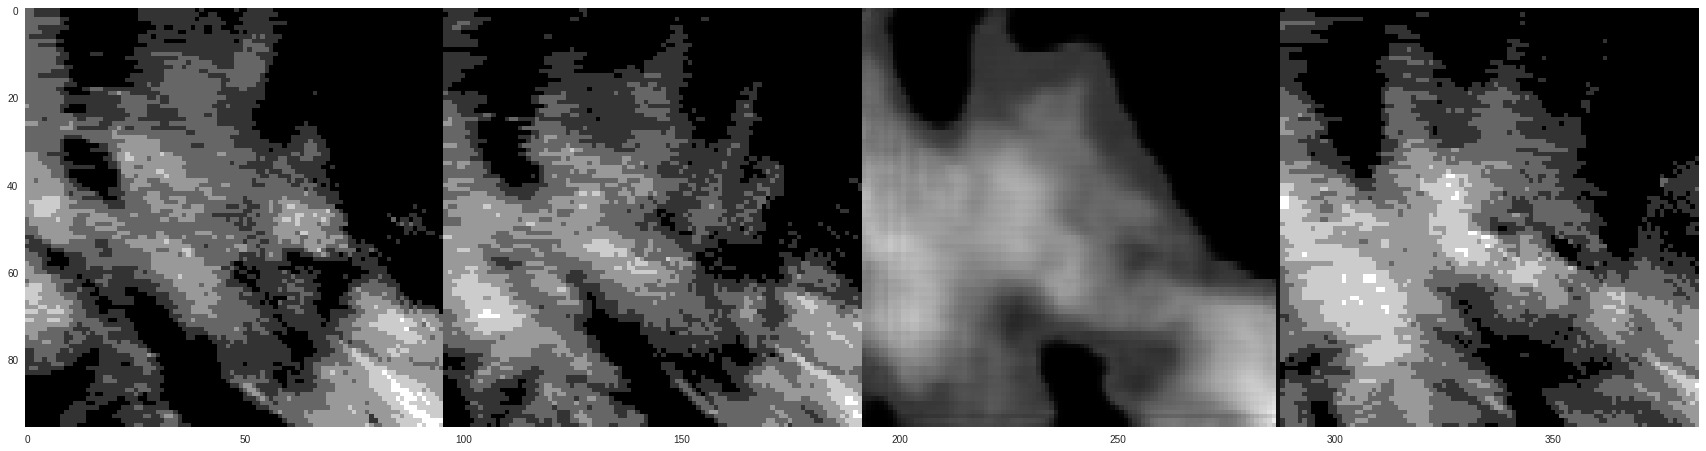

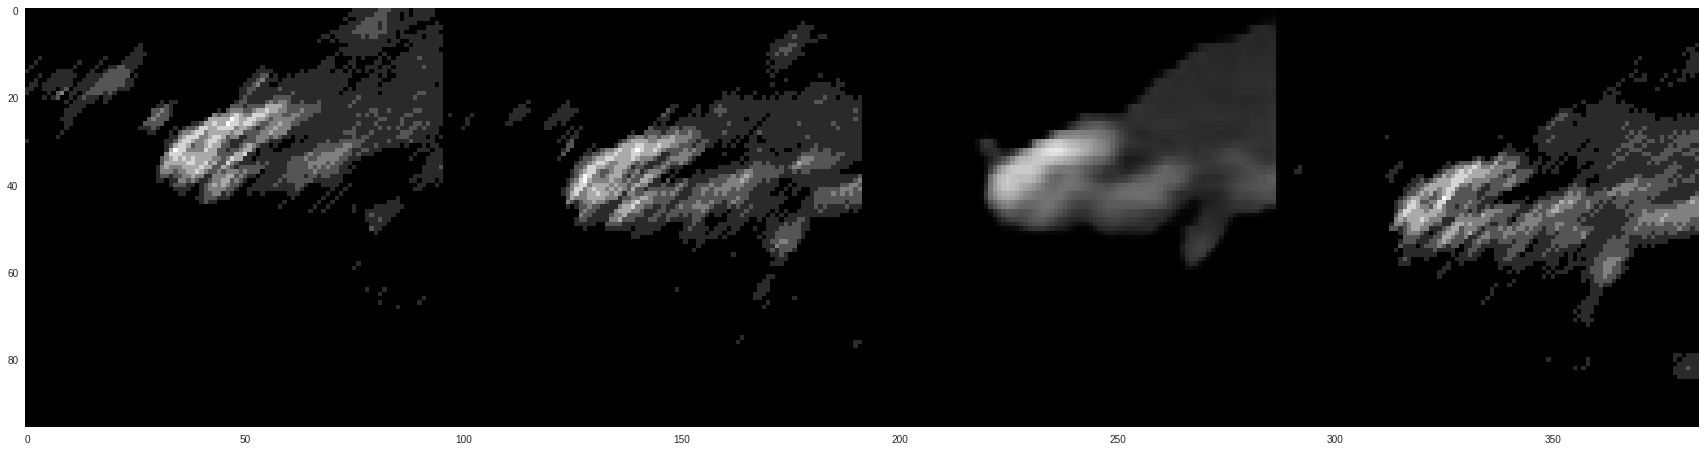

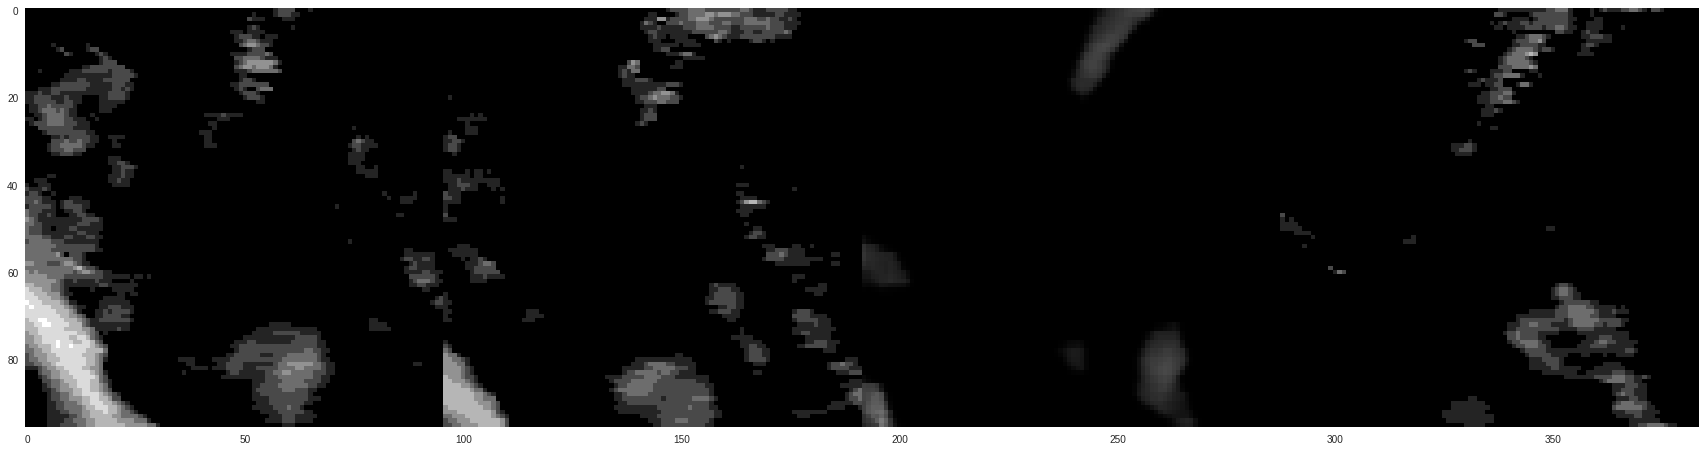

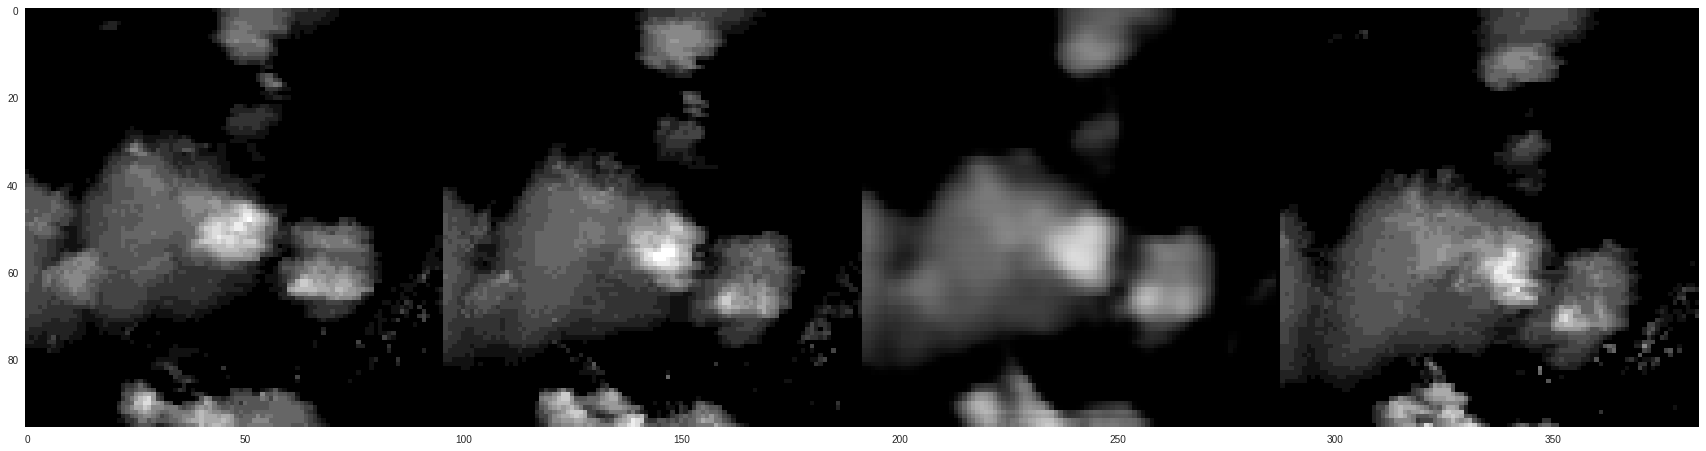

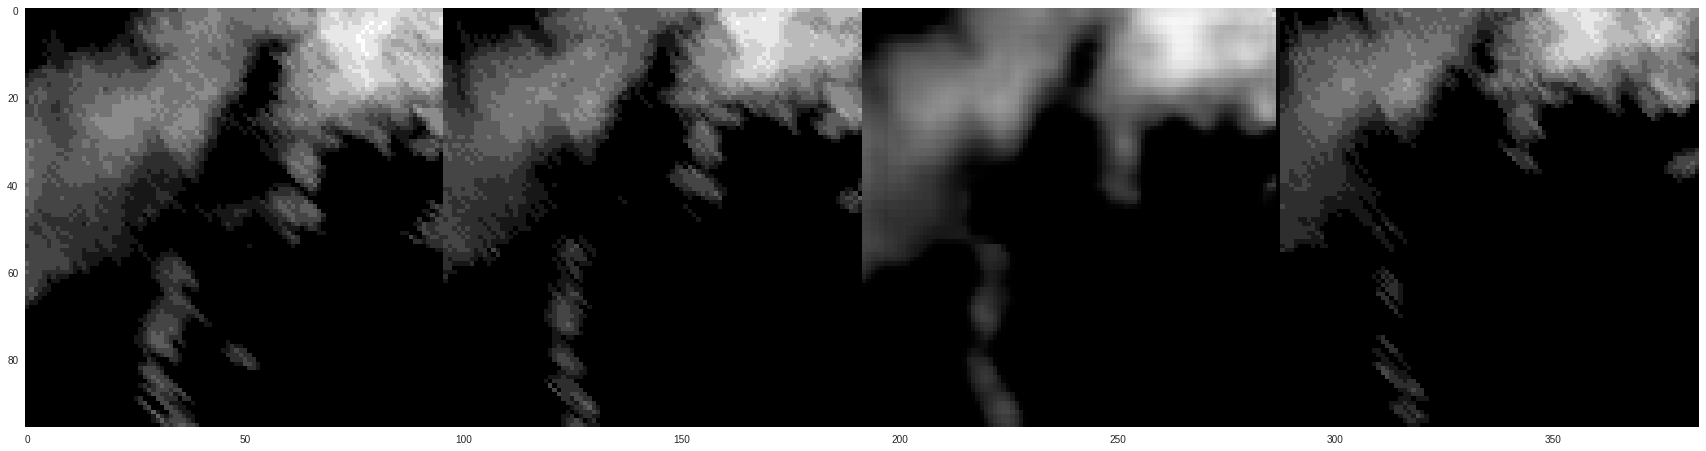

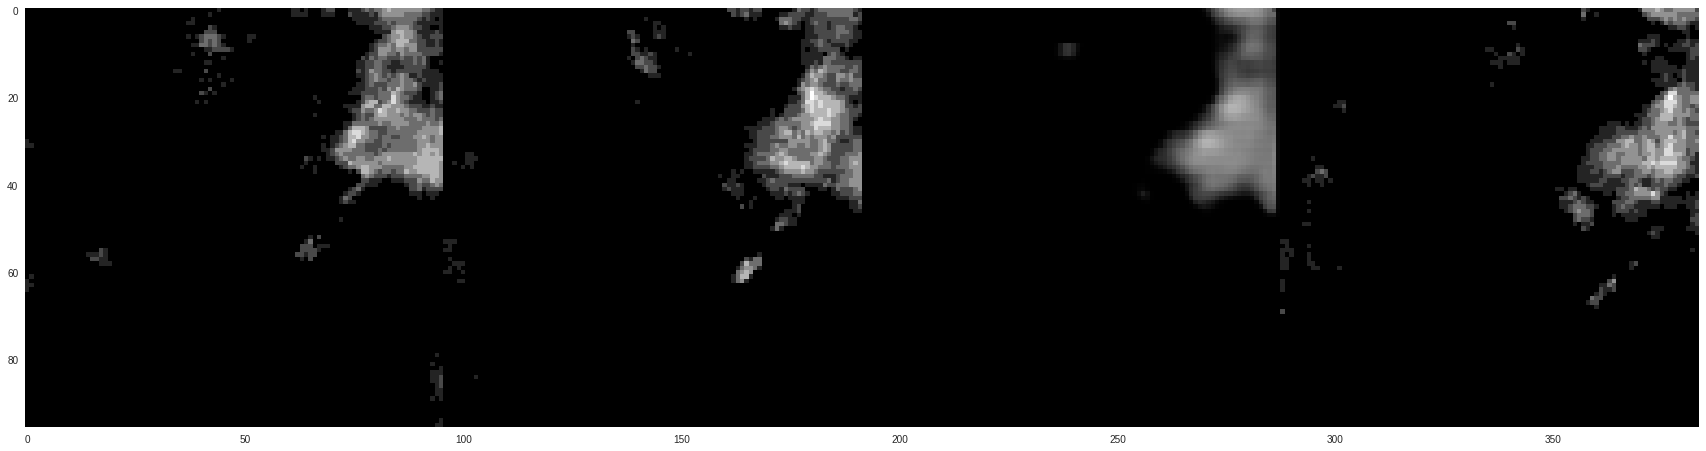

In [23]:
N = 10

res = autoencoder.predict(X_test[:10])

for i in range(10):
  compareRes(i,"")

In [25]:
!zip fig.zip *.png

  adding: 00.png (deflated 1%)
  adding: 01.png (deflated 3%)
  adding: 02.png (deflated 1%)
  adding: 03.png (deflated 2%)
  adding: 04.png (deflated 3%)
  adding: 05.png (deflated 1%)
  adding: 06.png (deflated 1%)
  adding: 07.png (deflated 1%)
  adding: 08.png (deflated 1%)
  adding: 09.png (deflated 1%)


In [28]:
!zip -r weights.zip 09/

  adding: 09/ (stored 0%)
  adding: 09/checkpoint (deflated 34%)
  adding: 09/cp.data-00000-of-00001 (deflated 8%)
  adding: 09/cp.index (deflated 69%)
